In [2]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

device = torch.accelerator.current_accelerator() if torch.accelerator.is_available() else "cpu"
device

device(type='cuda')

In [3]:
df_train = pd.read_csv("data/GTSRB/Train.csv")
df_test = pd.read_csv("data/GTSRB/Test.csv")
df_meta = pd.read_csv("data/GTSRB/Meta.csv")

print(f"Training data size : {len(df_train)}")
print(f"Testing data size : {len(df_test)}")
print(f"Number of classes : {len(df_meta)}")


Training data size : 39209
Testing data size : 12630
Number of classes : 43


In [4]:
print(df_train["ClassId"].value_counts() ,end="\n\n")
print(f"Mean size by class id : {df_train["ClassId"].value_counts().mean():.0f}")

ClassId
2     2250
1     2220
13    2160
12    2100
38    2070
10    2010
4     1980
5     1860
25    1500
9     1470
7     1440
3     1410
8     1410
11    1320
18    1200
35    1200
17    1110
14     780
31     780
33     689
15     630
26     600
28     540
23     510
30     450
6      420
16     420
34     420
22     390
36     390
20     360
40     360
21     330
39     300
24     270
29     270
27     240
32     240
41     240
42     240
0      210
19     210
37     210
Name: count, dtype: int64

Mean size by class id : 912


Showing some sample images

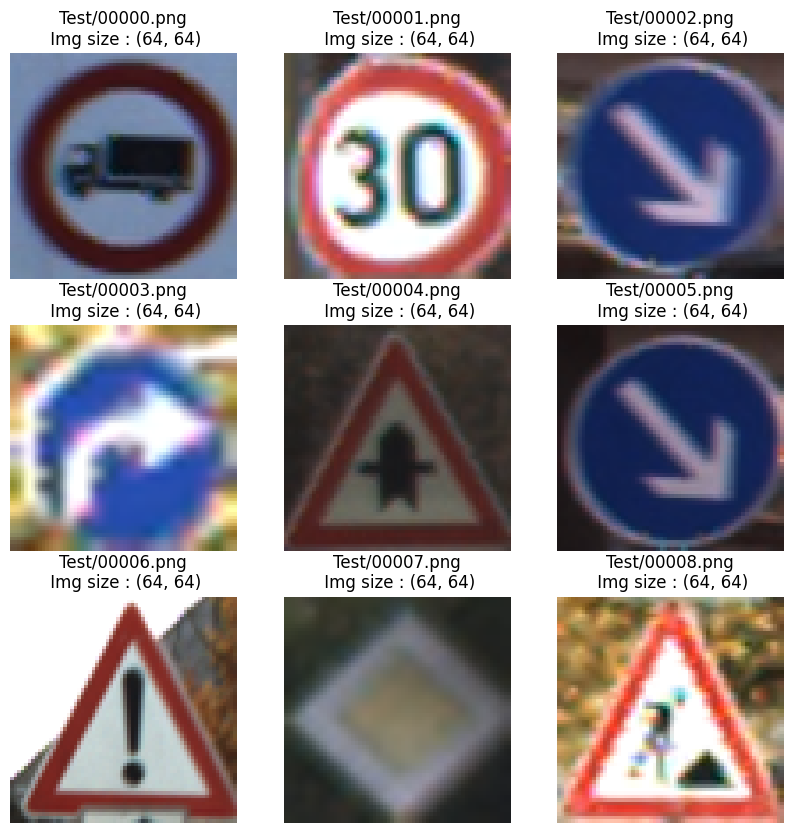

In [5]:

figure = plt.figure(figsize=(10, 10))
cols, rows = 3, 3
target_size = (64, 64)

for i in range(0, cols * rows):
    curr = df_test[["Path", "ClassId", "Roi.X1", "Roi.Y1", "Roi.X2", "Roi.Y2"]].iloc[i]

    # Show region of interest
    roi_pos = (curr["Roi.X1"], curr["Roi.Y1"])
    roi_width = curr["Roi.X2"] - curr["Roi.X1"]
    roi_height = curr["Roi.Y2"] - curr["Roi.Y1"]

    my_img = Image.open(f"data/GTSRB/{curr.Path}")
    img = my_img.crop((curr["Roi.X1"], curr["Roi.Y1"], curr["Roi.X2"], curr["Roi.Y2"])).resize(target_size)

    figure.add_subplot(rows, cols, i+1)
    plt.title(f"{curr.Path}\n Img size : {img.size}")
    plt.axis("off")
    plt.imshow(np.asarray(img))
plt.show()

In [6]:
def preprocess_image(row, resize=(64, 64)) -> Image:
    img_path = f"data/GTSRB/{row["Path"]}"
    img = Image.open(img_path)
    img = img.crop((row["Roi.X1"], row["Roi.Y1"], row["Roi.X2"], row["Roi.Y2"])).resize(resize)
    return img

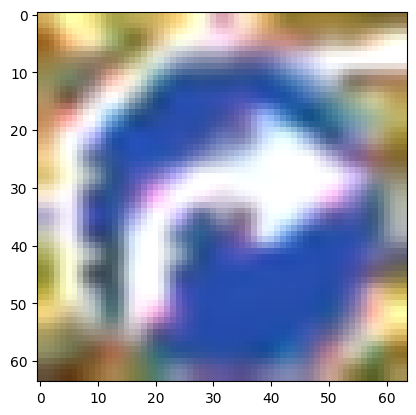

In [7]:
img = preprocess_image(df_test.iloc[3])
plt.imshow(img)

In [8]:
class RoadSignDataset(Dataset):
    def __init__(self, data_file, data_root="data/GTSRB", img_size=(64, 64), transform=None):
        df = pd.read_csv(data_file)
        
        self.labels = []
        self.images = []
        self.transform = transform
        
        for _, row in df.iterrows():
            # Load image and make it a tensor
            img_path = f"{data_root}/{row['Path']}"
            img = Image.open(img_path)
            img = img.crop((row["Roi.X1"], row["Roi.Y1"], row["Roi.X2"], row["Roi.Y2"]))
            img = img.resize(img_size)

            img_array = np.asarray(img, dtype=np.float32) / 255.0
            img_tensor = torch.from_numpy(img_array).permute(2, 0, 1)
            
            self.images.append(img_tensor)
            self.labels.append(row["ClassId"])
        
        self.labels = torch.tensor(self.labels, dtype=torch.long)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label


In [9]:
train_data = RoadSignDataset(data_file="data/GTSRB/Train.csv")
test_data = RoadSignDataset(data_file="data/GTSRB/Test.csv")

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

In [10]:
images, labels = next(iter(train_loader))
print(images.shape)
print(labels.shape)

torch.Size([16, 3, 64, 64])
torch.Size([16])


In [11]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Conv2d(in_channels= 3, out_channels=16, kernel_size=3), # 62x62 <= 64-kernel+1
            nn.ReLU(),
            nn.MaxPool2d(2), # 31x31
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5), # 27x27
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(in_features=32*27*27, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=43)
        )

    def forward(self, x):
        return self.layer_stack(x)

In [12]:
# Just testing if the dims ard guuuud
model = NeuralNetwork()
dummy_input = torch.randn(1, 3, 64, 64)
output = model(dummy_input)
print(output.shape)


torch.Size([1, 43])


In [13]:
def train_loop(dataloader: DataLoader, model, loss_fn, optimizer, batch_size):
    size = len(dataloader.dataset)

    model.train()
    for batch, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device)
        
        pred = model(images)
        loss = loss_fn(pred, labels)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(images)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [14]:
def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            pred = model(images)
            test_loss += loss_fn(pred, labels).item()
            correct += (pred.argmax(1) == labels).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


In [15]:
learning_rate = 1e-3
batch_size = 16
epochs = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [16]:
for t in range(epochs):
    print(f"Epoch {t + 1}\n{"-"*20}")
    train_loop(train_loader, model.to(device), loss_fn=loss_fn, optimizer=optimizer, batch_size=batch_size)
    test_loop(test_loader, model.to(device), loss_fn)
print("Done !")

Epoch 1
--------------------
loss: 3.761729  [   16/39209]
loss: 2.332088  [ 1616/39209]
loss: 1.172813  [ 3216/39209]
loss: 1.288758  [ 4816/39209]
loss: 0.419483  [ 6416/39209]
loss: 0.602394  [ 8016/39209]
loss: 0.345732  [ 9616/39209]
loss: 0.552937  [11216/39209]
loss: 0.412584  [12816/39209]
loss: 0.301711  [14416/39209]
loss: 0.167055  [16016/39209]
loss: 2.008029  [17616/39209]
loss: 0.088377  [19216/39209]
loss: 0.136223  [20816/39209]
loss: 0.078001  [22416/39209]
loss: 0.102564  [24016/39209]
loss: 0.357015  [25616/39209]
loss: 0.022888  [27216/39209]
loss: 0.001273  [28816/39209]
loss: 0.571732  [30416/39209]
loss: 0.011047  [32016/39209]
loss: 0.068286  [33616/39209]
loss: 0.484401  [35216/39209]
loss: 0.008675  [36816/39209]
loss: 0.022441  [38416/39209]
Test Error: 
 Accuracy: 90.0%, Avg loss: 0.445735 

Epoch 2
--------------------
loss: 0.393389  [   16/39209]
loss: 0.197556  [ 1616/39209]
loss: 0.123423  [ 3216/39209]
loss: 0.157161  [ 4816/39209]
loss: 0.014298  [ 64

In [17]:
torch.save(model, "model.pth")


In [20]:
def predict_image(model, image_path):
    print(f"\nPrediction for image : {image_path}")
    img = Image.open(image_path)
    img = img.resize((64, 64))
    img_array = np.asarray(img, dtype=np.float32) / 255.0
    img_tensor = torch.from_numpy(img_array).permute(2, 0, 1)[:3, :, :].unsqueeze(0) # Remove alpha channel
    img_tensor = img_tensor.to(device)
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        result = output.argmax(1).item()
        probs = nn.functional.softmax(output, dim=1)
        top_probs, top_indices = torch.topk(probs, k=3, dim=1)
        top_probs = top_probs.squeeze().tolist()
        top_indices = top_indices.squeeze().tolist()

        for i,  (prob, idx) in enumerate(zip(top_probs, top_indices)):
            print(f"Class {idx}: {prob * 100:.1f}%")

In [21]:
predict_image(model, "own_test/panneau_dodane.png")
predict_image(model, "own_test/double_arrow.png")
predict_image(model, "own_test/double_arrow_2.png")
predict_image(model, "own_test/train.png")
predict_image(model, "own_test/speed_limit_60.png")
predict_image(model, "own_test/speed_change_80.png")
predict_image(model, "own_test/double_arrow_3.png")


Prediction for image : own_test/panneau_dodane.png
Class 22: 100.0%
Class 29: 0.0%
Class 24: 0.0%

Prediction for image : own_test/double_arrow.png
Class 39: 88.1%
Class 4: 11.9%
Class 33: 0.0%

Prediction for image : own_test/double_arrow_2.png
Class 37: 100.0%
Class 39: 0.0%
Class 35: 0.0%

Prediction for image : own_test/train.png
Class 25: 99.8%
Class 29: 0.2%
Class 24: 0.0%

Prediction for image : own_test/speed_limit_60.png
Class 3: 100.0%
Class 5: 0.0%
Class 2: 0.0%

Prediction for image : own_test/speed_change_80.png
Class 32: 99.7%
Class 6: 0.3%
Class 12: 0.0%

Prediction for image : own_test/double_arrow_3.png
Class 36: 100.0%
Class 34: 0.0%
Class 33: 0.0%


Create a confusion matrix

In [22]:
all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images.to(device))
        preds = outputs.argmax(1).cpu()
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

Text(120.72222222222221, 0.5, 'Actual')

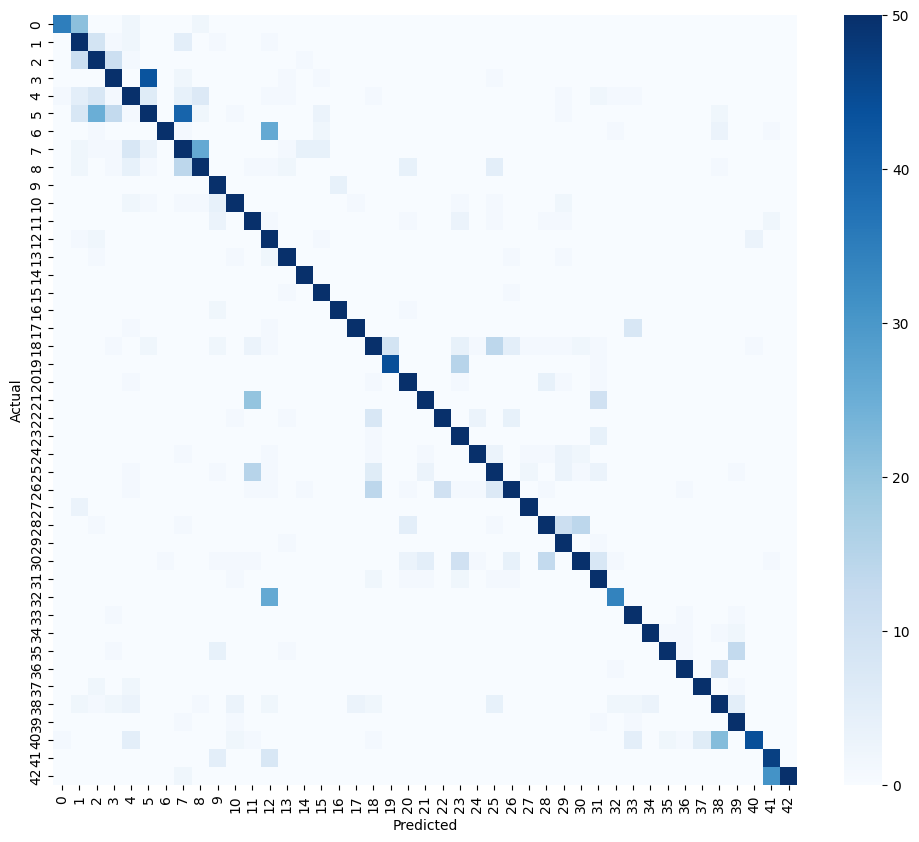

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=False, cmap='Blues', vmax=50)  # annot=True shows numbers but cluttered with 43 classes
plt.xlabel("Predicted")
plt.ylabel("Actual")